In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, roc_curve, auc
from scipy.stats import randint, norm
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import matplotlib as mpl
from matplotlib import font_manager
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
try:
    if "Fira Sans" in [f.name for f in font_manager.fontManager.ttflist]:
        mpl.rcParams["font.family"] = "Fira Sans"
    else:
        raise KeyError("No Fira Sans? :3")
except:
    try:
        for font in os.listdir(os.path.join(os.path.dirname(os.getcwd()), "fonts")):
            font_manager.fontManager.addfont(os.path.join(os.path.join(os.path.dirname(os.getcwd()), "fonts"), font))
        font_manager.fontManager = font_manager.FontManager()
        if "Fira Sans" in [f.name for f in font_manager.fontManager.ttflist]:
            mpl.rcParams["font.family"] = "Fira Sans"
        else:
            raise ValueError("No Fira Sans in fonts folder...")
    except:
        mpl.rcParams["font.family"] = "DejaVu Sans"
filtered_tgss = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'reduced_TgSS.csv'))
features = list(set(filtered_tgss.columns)-set(["Tg", "SMILES", "Polymer Class"]+[col for col in filtered_tgss.columns if col.startswith("poly")]))
X = filtered_tgss[features].copy()
y_Tg = filtered_tgss["Tg"].copy()
y_PC = filtered_tgss[[col for col in filtered_tgss.columns if col.startswith("poly")]].copy()

In [2]:
with open(os.path.join(os.getcwd(), "plotting_help.json"), "r") as f:
    plotting_help = json.load(f)
abbrev = plotting_help["abbrev"]

In [3]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_Tg, test_size=0.2, random_state=0)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_PC, test_size=0.2, random_state=0)
regressor = GradientBoostingRegressor()
classifier = MultiOutputClassifier(GradientBoostingClassifier())

In [4]:
if os.path.exists(os.path.join(os.path.dirname(os.getcwd()), 'hyperparameters', 'GradientBoostingRegressor.json')):
    print("Hyperparameter json file found for GradientBoostingRegressor.")
    with open(os.path.join(os.path.dirname(os.getcwd()), 'hyperparameters', 'GradientBoostingRegressor.json'), "r") as f:
        best_params_r = json.load(f)
    print(best_params_r)
else:
    print("No hyperparameter json file found, buckle in, this is going to take a while.")
    param_distributions = {
        'n_estimators': randint(50, 1200),
        'max_features': ['sqrt', 'log2', 0.625, 0.8],
        'learning_rate': [0.05, 0.1, 0.15, 0.3],
        'max_depth': randint(5, 40)
    }
    random_search = RandomizedSearchCV(regressor, param_distributions, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=0)
    random_search.fit(X_train_r, y_train_r)
    best_params_r = random_search.best_params_
    with open(os.path.join(os.path.dirname(os.getcwd()), 'hyperparameters', 'GradientBoostingRegressor.json'), "w") as f:
        json.dump(best_params_r, f, indent=4)
    print(best_params_r)

Hyperparameter json file found for GradientBoostingRegressor.
{'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 828}


In [5]:
sample_weights = np.ones(len(y_train_c))
n_labels = y_train_c.shape[1]
for i in range(n_labels):
    label = y_train_c.to_numpy()[:, i]
    pos_weight = (len(label) - label.sum()) / label.sum()
    sample_weights[label == 1] *= pos_weight
if os.path.exists(os.path.join(os.path.dirname(os.getcwd()), 'hyperparameters', 'GradientBoostingMultiOutputClassifier.json')):
    print("Hyperparameter json file found for GradientBoostingMultiOutputClassifier.")
    with open(os.path.join(os.path.dirname(os.getcwd()), 'hyperparameters', 'GradientBoostingMultiOutputClassifier.json'), "r") as f:
        best_params_c = json.load(f)
    print(best_params_c)
else:
    print("No hyperparameter json file found, buckle in, this is going to take a while.")
    param_distributions = {
        'estimator__n_estimators': randint(50, 1200),
        'estimator__max_features': ['sqrt', 'log2', 0.625, 0.8],
        'estimator__learning_rate': [0.05, 0.1, 0.15, 0.3],
        'estimator__max_depth': randint(5, 40)
    }
    random_search = RandomizedSearchCV(classifier, param_distributions, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=0)
    random_search.fit(X_train_c, y_train_c, sample_weight=sample_weights)
    best_params_c = random_search.best_params_
    best_params_c = {key[11:]:value for key, value in best_params_c.items()}
    with open(os.path.join(os.path.dirname(os.getcwd()), 'hyperparameters', 'GradientBoostingMultiOutputClassifier.json'), "w") as f:
        json.dump(best_params_c, f, indent=4)
    print(best_params_c)

Hyperparameter json file found for GradientBoostingMultiOutputClassifier.
{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 0.8, 'n_estimators': 813}


In [6]:
regressor = GradientBoostingRegressor(random_state=0, **best_params_r)
regressor.fit(X_train_r, y_train_r)
y_pred_r = regressor.predict(X_test_r)
mae = mean_absolute_error(y_test_r, y_pred_r)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 26.9455293663984


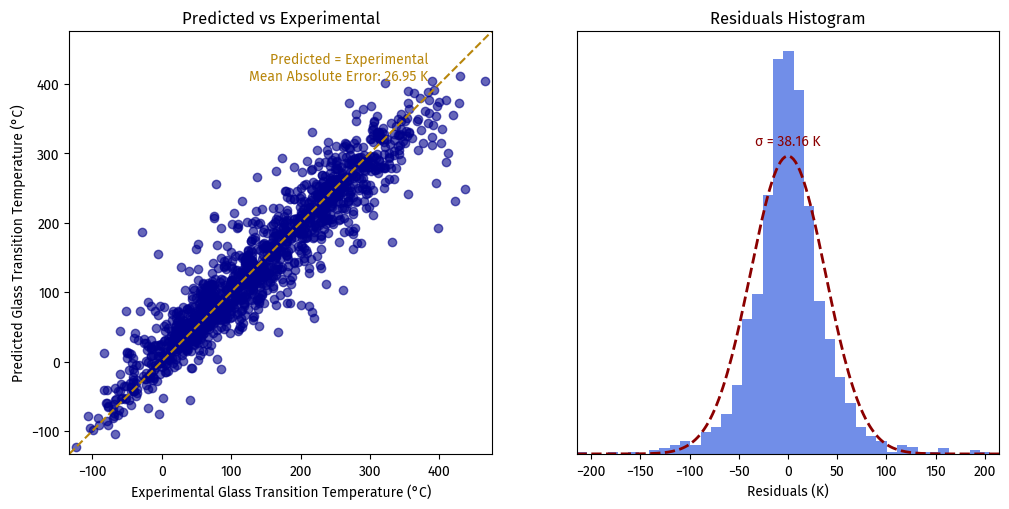

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 2]})
# fig.suptitle(f"Random Forest Regressor")
ax1.scatter(y_test_r, y_pred_r, alpha=0.6, color='darkblue')
ax1.axline((0, 0), slope=1, c='darkgoldenrod', ls='--')
ax1.set_aspect('equal', adjustable='box')
lims = [min(np.min(y_test_r), np.min(y_pred_r)) - 10, 
        max(np.max(y_test_r), np.max(y_pred_r)) + 10]
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_xlabel('Experimental Glass Transition Temperature (°C)')
ax1.set_ylabel('Predicted Glass Transition Temperature (°C)')
ax1.set_title('Predicted vs Experimental')
ax1.text(0.85, 0.95, f'Predicted = Experimental\nMean Absolute Error: {mae:.2f} K', transform=ax1.transAxes, horizontalalignment='right', verticalalignment='top', color='darkgoldenrod')
bin_c = 40
counts, bins, patches = ax2.hist(y_test_r - y_pred_r, bins=bin_c, alpha=0.75, color='royalblue')
xmax = max(-bins[0], bins[-1])
xmin = -xmax
x = np.linspace(xmin, xmax, 200)
amplitude = len(y_test_r - y_pred_r)*(xmax-xmin)/bin_c
sigma = np.sqrt(np.var(y_test_r - y_pred_r))
ax2.plot(x, norm.pdf(x, 0, sigma)*amplitude, c='darkred', ls = '--', lw=2)
ax2.set_xlim((xmin, xmax))
ax2.set_xlabel('Residuals (K)')
ax2.set_yticks([])
ax2.set_title(f'Residuals Histogram')
ax2.text(0, norm.pdf(0, 0, sigma)*amplitude*1.05, f'σ = {sigma:.2f} K', horizontalalignment='center', verticalalignment='center', color = 'darkred')
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.set_aspect((xmax-xmin)/(ymax-ymin), adjustable='box')
plt.show()

In [8]:
classifier = MultiOutputClassifier(GradientBoostingClassifier(random_state=0, **best_params_c))
classifier.fit(X_train_c, y_train_c, sample_weight=sample_weights)
y_pred_c = classifier.predict(X_test_c)
accuracy = accuracy_score(y_test_c, y_pred_c)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9251887439945092


C:\Users\Andy\AppData\Local\Temp\ipykernel_33780\3015798643.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', n_classes)


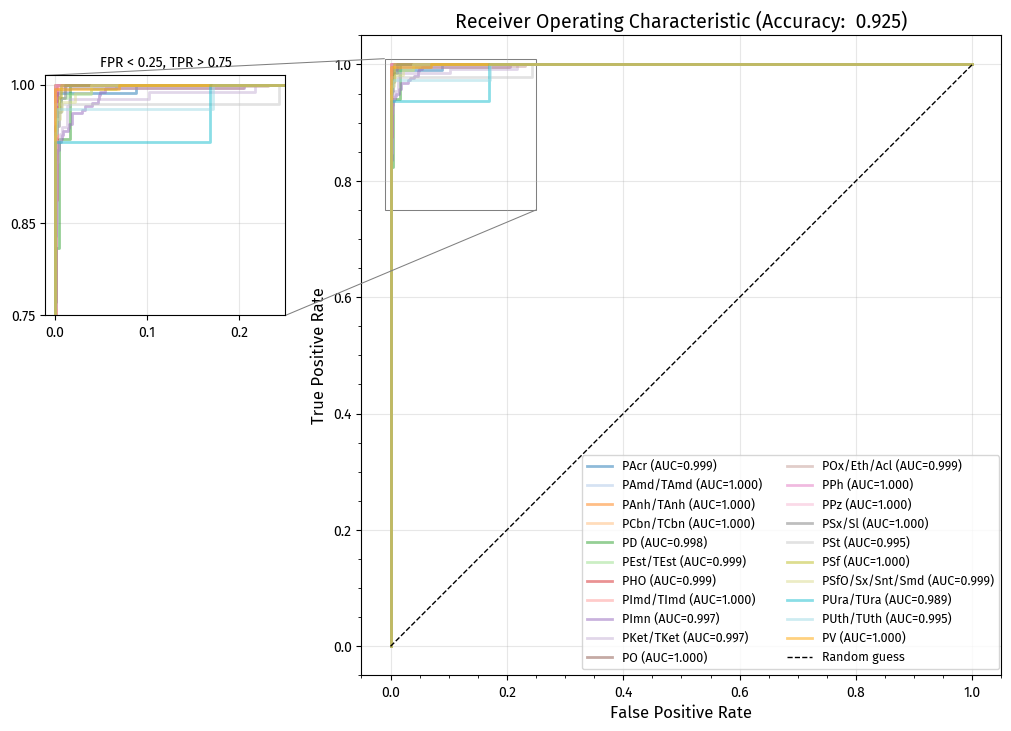

In [9]:
y_pred_proba = classifier.predict_proba(X_test_c)
n_classes = y_test_c.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_c.to_numpy()[:, i], y_pred_proba[i][:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig = plt.figure(figsize=(12, 8))
main_ax = fig.add_axes([0.2, 0.1, 0.7, 0.8])
main_ax.set_aspect('equal', adjustable='box')
colors = plt.cm.get_cmap('tab20', n_classes)
for i in range(n_classes):
    label = abbrev.get(y_test_c.columns[i], y_test_c.columns[i])
    main_ax.plot(fpr[i], tpr[i], color=colors(i) if i < 20 else 'orange', lw=2, alpha=0.5, label=f"{label} (AUC={roc_auc[i]:.3f})")
main_ax.plot([0,1], [0,1], 'k--', lw=1, label='Random guess')
main_ax.set_xlabel('False Positive Rate', fontsize=12)
main_ax.set_ylabel('True Positive Rate', fontsize=12)
main_ax.set_title(f'Receiver Operating Characteristic (Accuracy: {accuracy: .3f})', fontsize=14)
main_ax.grid(alpha=0.3)
main_ax.minorticks_on()
inset_ax = fig.add_axes([0.02, 0.5, 0.2, 0.4])
inset_ax.set_aspect('equal', adjustable='box')
for i in range(n_classes):
    inset_ax.plot(fpr[i], tpr[i], color=colors(i) if i < 20 else 'orange', lw=2, alpha=0.5)
inset_ax.plot([0,1], [0,1], 'k--', lw=1)
inset_ax.set_xlim(-0.01, 0.25)
inset_ax.set_ylim(0.75, 1.01)
inset_ax.set_xticks([0, 0.1, 0.2])
inset_ax.set_yticks([0.75, 0.85, 1])
inset_ax.grid(alpha=0.3)
inset_ax.set_title('FPR < 0.25, TPR > 0.75', fontsize=10)
mark_inset(main_ax, inset_ax, loc1=2, loc2=4, ec="0.5", lw=0.75)
fig.legend(loc='lower right', bbox_to_anchor=(0.82, 0.1), ncol=2, fontsize=9)

plt.show()